In [1]:
#!g1.1
from sklearn.preprocessing import LabelEncoder
import transformers
import torch
import nltk
import numpy as np
import pandas as pd

In [2]:
#!g1.1
from datasets import load_dataset

dataset_train_test_val = load_dataset('json', 
                                  data_files={'train': 'train_dataset.json', 'test': 'test_dataset.json', 'val': 'val_dataset.json'})

Using custom data configuration default


Dataset json downloaded and prepared to /tmp/xdg_cache/huggingface/datasets/json/default-71bc0cd49f840871/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514. Subsequent calls will reuse this data.


In [3]:
#!g1.1
dataset_train_test_val

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 44928
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 11981
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14976
    })
})

In [4]:
#!g1.1
train_dataset = dataset_train_test_val['train']
val_dataset = dataset_train_test_val['val']
test_dataset = dataset_train_test_val['test']

In [5]:
#!g1.1
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

In [6]:
#!g1.1
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [7]:
#!g1.1
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=8)
model = model.to(device)

trainer = Trainer(
    model=model, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    args=TrainingArguments(
        output_dir="./my_saved_model", overwrite_output_dir=True,
        num_train_epochs=4, per_device_train_batch_size=32,
        save_steps=10000, save_total_limit=2),
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [13]:
#!g1.1
trainer.train()

***** Running training *****
  Num examples = 44928
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5616




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=5616, training_loss=0.06720576955382301, metrics={'train_runtime': 3209.8809, 'train_samples_per_second': 55.987, 'train_steps_per_second': 1.75, 'total_flos': 2.380852842253517e+16, 'train_loss': 0.06720576955382301, 'epoch': 4.0})

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [47]:
#!g1.1
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 14976
  Batch size = 8


{'eval_loss': 0.5749701261520386,
 'eval_accuracy': 0.8629807692307693,
 'eval_runtime': 122.7376,
 'eval_samples_per_second': 122.016,
 'eval_steps_per_second': 15.252,
 'epoch': 4.0}

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [48]:
#!g1.1
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /tmp/xdg_cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.17.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /tmp/xdg_cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915d

In [40]:
#!g1.1
dict_label = {'math': 3,
              'physics': 4,
              'q-bio': 5,
              'cs': 0,
              'q-fin': 6,
              'stat': 7,
              'eess': 2,
              'econ': 1}

In [41]:
#!g1.1
inv_map = {v: k for k, v in dict_label.items()}
inv_map

{3: 'math',
 4: 'physics',
 5: 'q-bio',
 0: 'cs',
 6: 'q-fin',
 7: 'stat',
 2: 'eess',
 1: 'econ'}

In [99]:
#!g1.1
text = """mathematics"""
tokens = tokenizer.encode(text)
with torch.no_grad():
    logits = model(torch.as_tensor([tokens], device=device))[0]
    probs = torch.softmax(logits[-1, :], dim=-1).data.cpu().numpy()
probs

array([1.15543455e-02, 2.51640333e-03, 2.27772980e-03, 9.46712017e-01,
       4.27448237e-03, 8.11084581e-04, 2.39739451e-03, 2.94565000e-02],
      dtype=float32)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [100]:
#!g1.1
idx_label = np.argsort(probs)[::-1]

sum_probs = 0
prediction_probs = []
prediction_classes = []

idx = 0
while sum_probs < 0.95:
    cur_predict = inv_map[idx_label[idx]]
    cur_probs = probs[idx_label[idx]]
    
    sum_probs += cur_probs
    
    prediction_probs.append(cur_probs)
    prediction_classes.append(cur_predict)
    
    idx += 1

print(prediction_probs)
print(prediction_classes)

[0.946712, 0.0294565]
['math', 'stat']


In [117]:
#!g1.1
def predict_label(title, summary, tokenizer, model, inv_map):
    abstract = title.lower() + '. ' + summary.lower()
    token_text = tokenizer.encode(abstract)
    
    with torch.no_grad():
        logits = model(torch.as_tensor([token_text], device=device))[0]
        probs = torch.softmax(logits[-1, :], dim=-1).data.cpu().numpy()
    
    idx_label = np.argsort(probs)[::-1]

    sum_probs = 0
    prediction_probs = []
    prediction_classes = []

    idx = 0
    while sum_probs < 0.95:
        cur_predict = inv_map[idx_label[idx]]
        cur_probs = probs[idx_label[idx]]
    
        sum_probs += cur_probs
    
        prediction_probs.append(cur_probs)
        prediction_classes.append(cur_predict)
    
        idx += 1
    
    return prediction_classes, prediction_probs, probs

In [148]:
#!g1.1
title = "strategic behaviour and indicative price diffusion in paris stock   exchange auctions"
summary = "we report statistical regularities of the opening and closing auctions of french equities, focusing on the diffusive properties of the indicative auction price. two mechanisms are at play as the auction end time nears: the typical price change magnitude decreases, favoring underdiffusion, while the rate of these events increases, potentially leading to overdiffusion. a third mechanism, caused by the strategic behavior of traders, is needed to produce nearly diffusive prices: waiting to submit buy orders until sell orders have decreased the indicative price and vice-versa."

prediction_classes, prediction_probs, probs = predict_label(title, summary, tokenizer, model, inv_map)

In [ ]:
#!g1.1
prediction_classes, prediction_probs, probs = predict_label(title, summary, tokenizer, model, inv_map)
    
data = pd.DataFrame({'Categories' : tag, 'Probs' : probs})
data = data.sort_values(by='Probs', ascending=False)

In [ ]:
#!g1.1
data

In [ ]:
#!g1.1
зд

<AxesSubplot:>

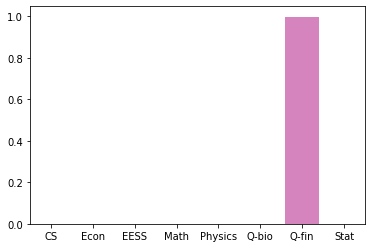

In [140]:
#!g1.1
import seaborn as sns

tag = ['CS', 'Econ', 'EESS', 
       'Math', 'Physics', 'Q-bio', 'Q-fin', 'Stat']

sns.barplot(x=tag, y=probs)

In [149]:
#!g1.1


'┈┏╮┈┈┈╭┓┈┈╭┳━╮┈\u2003\n┈┃┗━━━┛┃┈┈╰┻╮┃┈\u2003\n┈┃╰╯┈╰╯┣━━━╮┃┃┈\u2003\n┈┃┈┈▲┈┈┃┈╭━┣╯┃┈\u2003\n┈╰┳╰━╯┳╯╭┛┈┣━╯┈\u2003\n┈┈╰╯┈╰╯┈╰━━╯┈┈┈'

In [145]:
#!g1.1
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(x=tag, y=probs, bins=20)

plt.pyplot(fig)

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

/kernel/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: setting an array element with a sequence.

<Figure size 432x288 with 1 Axes>

In [144]:
#!g1.1
model.save_pretrained("my_beautiful_model")

Configuration saved in my_beautiful_model/config.json
Model weights saved in my_beautiful_model/pytorch_model.bin
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)
